In [1]:
!pip install tldextract
!pip install python-whois
import os
import sys
import re
import matplotlib
import pandas as pd
import numpy as np
from os.path import splitext
import ipaddress as ip
import tldextract
import whois
import datetime
from urllib.parse import urlparse

In [37]:
# df = pd.read_csv("Desktop/url_spam_classification.csv")
df=pd.read_csv("Desktop/url_spam_classification.csv")
# df=df.sample(frac=1)
# df = df.sample(frac=1).reset_index(drop=True)
df.head()

,URL,Lable
0,https://www.nbcnews.com/tech/tech-news/whitmer...,0
1,https://substack.com/,1
2,https://thehustle.co/12072020-diagnostic-start...,0
3,https://docs.google.com/forms/d/e/1FAIpQLSfDLO...,1
4,https://www.janefriedman.com/query-letter-mast...,1


In [38]:
len(df) #displaying 5 records

95028

In [4]:
#2016's top most suspicious TLD and words
Suspicious_TLD=['zip','cricket','link','work','party','gq','kim','country','science','tk']
Suspicious_Domain=['luckytime.co.kr','mattfoll.eu.interia.pl','trafficholder.com','dl.baixaki.com.br','bembed.redtube.comr','tags.expo9.exponential.com','deepspacer.com','funad.co.kr','trafficconverter.biz']
#trend micro's top malicious domains 

In [5]:
# Method to count number of dots
def countdots(url):  
    return url.count('.')

# Method to count number of delimeters
def countdelim(url):
    count = 0
    delim=[';','_','?','=','&']
    for each in url:
        if each in delim:
            count = count + 1
    
    return count

In [6]:
# Is IP addr present as th hostname, let's validate

import ipaddress as ip #works only in python 3

def isip(uri):
    try:
        if ip.ip_address(uri):
            return 1
    except:
        return 0

#method to check the presence of hyphens

def isPresentHyphen(url):
    return url.count('-')

In [7]:
#method to check the presence of @

def isPresentAt(url):
    return url.count('@')
def isPresentDSlash(url):
    return url.count('//')

In [8]:
def countSubDir(url):
    return url.count('/')

In [9]:
def get_ext(url):
    """Return the filename extension from url, or ''."""
    
    root, ext = splitext(url)
    return ext

In [10]:
def countSubDomain(subdomain):
    if not subdomain:
        return 0
    else:
        return len(subdomain.split('.'))

In [11]:
def countQueries(query):
    if not query:
        return 0
    else:
        return len(query.split('&'))

In [12]:
'''
featureSet = pd.DataFrame(columns=('url','no of dots','presence of hyphen','len of url','presence of at',\
'presence of double slash','no of subdir','no of subdomain','len of domain','no of queries','is IP','presence of Suspicious_TLD',\
'presence of suspicious domain','create_age(months)','expiry_age(months)','update_age(days)','country','file extension','label'))'''

featureSet = pd.DataFrame(columns=('url','no of dots','presence of hyphen','len of url','presence of at',\
'presence of double slash','no of subdir','no of subdomain','len of domain','no of queries','is IP','presence of Suspicious_TLD',\
'presence of suspicious domain','label'))

In [13]:
from urllib.parse import urlparse
import tldextract
def getFeatures(url, label): 
    result = []
    url = str(url)
    
    #add the url to feature set
    result.append(url)
    
    #parse the URL and extract the domain information
    path = urlparse(url)
    ext = tldextract.extract(url)
    
    #counting number of dots in subdomain    
    result.append(countdots(ext.subdomain))
    
    #checking hyphen in domain   
    result.append(isPresentHyphen(path.netloc))
    
    #length of URL    
    result.append(len(url))
    
    #checking @ in the url    
    result.append(isPresentAt(path.netloc))
    
    #checking presence of double slash    
    result.append(isPresentDSlash(path.path))
    
    #Count number of subdir    
    result.append(countSubDir(path.path))
    
    #number of sub domain    
    result.append(countSubDomain(ext.subdomain))
    
    #length of domain name    
    result.append(len(path.netloc))
    
    #count number of queries    
    result.append(len(path.query))
    
    #Adding domain information
    
    #if IP address is being used as a URL     
    result.append(isip(ext.domain))
    
    #presence of Suspicious_TLD
    result.append(1 if ext.suffix in Suspicious_TLD else 0)
    
    #presence of suspicious domain
    result.append(1 if '.'.join(ext[1:]) in Suspicious_Domain else 0 )
     
    '''
      
    #Get domain information by asking whois
    domain = '.'.join(ext[1:])
    w = whois.whois(domain)
    
    avg_month_time=365.2425/12.0
    
                  
    #calculate creation age in months
                  
    if w.creation_date == None or type(w.creation_date) is str :
        result.append(-1)
        #training_df['create_age(months)'] = -1
    else:
        if(type(w.creation_date) is list): 
            create_date=w.creation_date[-1]
        else:
            create_date=w.creation_date

        if(type(create_date) is datetime.datetime):
            today_date=datetime.datetime.now()
            create_age_in_mon=((today_date - create_date).days)/avg_month_time
            create_age_in_mon=round(create_age_in_mon)
            result.append(create_age_in_mon)
            #training_df['create_age(months)'] = create_age_in_mon
            
        else:
            result.append(-1)
            #training_df['create_age(months)'] = -1
    
    #calculate expiry age in months
                  
    if(w.expiration_date==None or type(w.expiration_date) is str):
        #training_df['expiry_age(months)'] = -1
        result.append(-1)
    else:
        if(type(w.expiration_date) is list):
            expiry_date=w.expiration_date[-1]
        else:
            expiry_date=w.expiration_date
        if(type(expiry_date) is datetime.datetime):
            today_date=datetime.datetime.now()
            expiry_age_in_mon=((expiry_date - today_date).days)/avg_month_time
            expiry_age_in_mon=round(expiry_age_in_mon)
            #training_df['expiry_age(months)'] = expiry_age_in_mon
            #### appending  in months Appended to the Vector
            result.append(expiry_age_in_mon)
        else:
            #training_df['expiry_age(months)'] = -1
            result.append(-1)#### expiry date error so append -1

    #find the age of last update
                  
    if(w.updated_date==None or type(w.updated_date) is str):
        #training_df['update_age(days)'] = -1
        result.append(-1)
    else:
        if(type(w.updated_date) is list):
            update_date=w.updated_date[-1]
        else:
            update_date=w.updated_date
        if(type(update_date) is datetime.datetime):
            today_date=datetime.datetime.now()
            update_age_in_days=((today_date - update_date).days)
            result.append(update_age_in_days)
            #training_df['update_age(days)'] = update_age_in_days #### appending updated age in days Appended to the Vector
        else:
            result.append(-1)
            #training_df['update_age(days)'] = -1
    
    #find the country who is hosting this domain
    if(w.country == None):
        #training_df['country'] = "None"
        result.append("None")
    else:
        #training_df['country'] = w.country
        result.append(w.country)
     ''' 
    
    #result.append(get_ext(path.path))
    result.append(str(label))
    return result
                  
    #Yay! finally done!  

In [14]:
for i in range(len(df)):
    features = getFeatures(df["URL"].loc[i], df["Lable"].loc[i])    
    featureSet.loc[i] = features 

In [15]:
featureSet.head()

,url,no of dots,presence of hyphen,len of url,presence of at,presence of double slash,no of subdir,no of subdomain,len of domain,no of queries,is IP,presence of Suspicious_TLD,presence of suspicious domain,label
0,https://www.allmusic.com/album/frank-black-mw0...,0,0,55,0,0,2,1,16,0,0,0,0,0
1,https://creativemornings.com/companies/zelos,0,0,44,0,0,2,0,20,0,0,0,0,0
2,https://thehustle.co/account/,0,0,29,0,0,2,0,12,0,0,0,0,1
3,https://www.karacutruzzula.com/,0,0,31,0,0,1,1,22,0,0,0,0,1
4,https://thehustle.co/12142020-Uber/,0,0,35,0,0,2,0,12,0,0,0,0,0


In [16]:
!pip install seaborn
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle as pkl
from __future__ import division

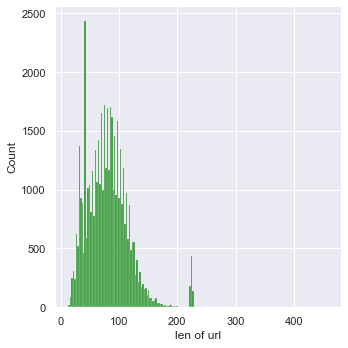

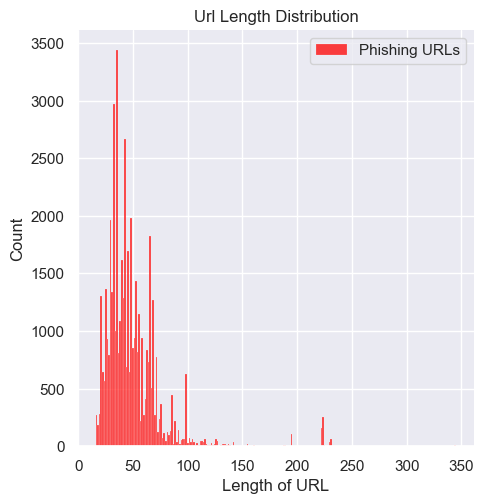

In [17]:
sns.set(style="darkgrid")
sns.displot(featureSet[featureSet['label']=='0']['len of url'],color='green',label='Benign URLs')
sns.displot(featureSet[featureSet['label']=='1']['len of url'],color='red',label='Phishing URLs')
plt.title('Url Length Distribution')
plt.legend(loc='upper right')
plt.xlabel('Length of URL')

plt.show()

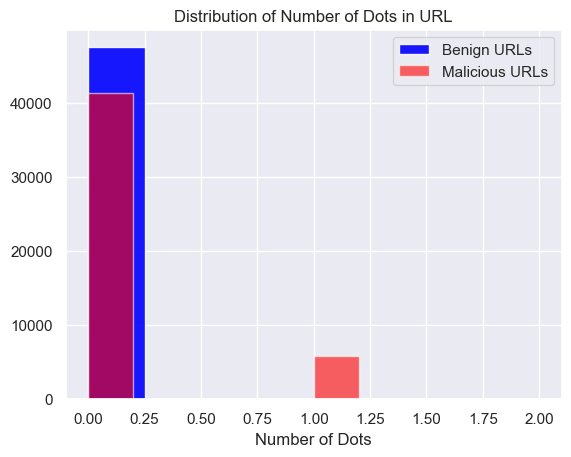

In [18]:
x=featureSet[featureSet['label']=='0']['no of dots']
y=featureSet[featureSet['label']=='1']['no of dots']
plt.hist(x,bins=8, alpha=0.9, label='Benign URLs',color='blue')
#sns.distplot(x,bins=8,color='blue',label='Benign URLs')
plt.hist(y,bins=10, alpha=0.6, label='Malicious URLs',color='red')
#sns.distplot(y,bins=8,color='red',label='Malicious URLs')
plt.legend(loc='upper right')
plt.xlabel('Number of Dots')
plt.title('Distribution of Number of Dots in URL')
plt.show()

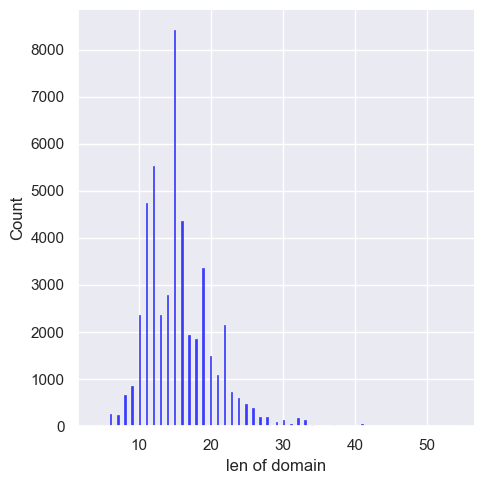

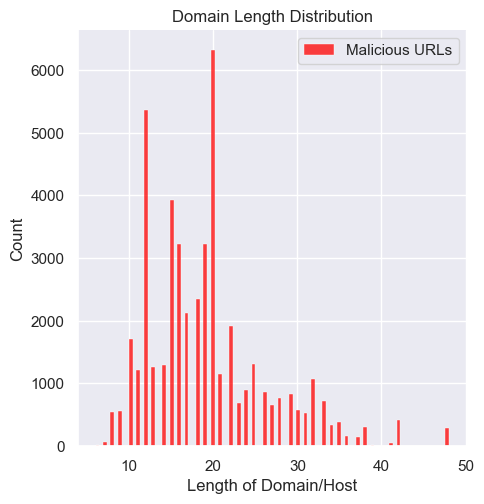

In [19]:
sns.set(style="darkgrid")
sns.displot(featureSet[featureSet['label']=='0']['len of domain'],color='blue',label='Benign URLs')
sns.displot(featureSet[featureSet['label']=='1']['len of domain'],color='red',label='Malicious URLs')
plt.title('Domain Length Distribution')
plt.legend(loc='upper right')
plt.xlabel('Length of Domain/Host')
plt.show()

In [20]:
'''
sns.set(style="whitegrid")
sns.distplot(featureSet[featureSet['label']==0]['create_age(months)'],color='green',label='Benign URLs')
sns.distplot(featureSet[featureSet['label']==1]['create_age(months)'],color='red',label='Malicious URLs')
sns.plt.title('Creation Age Distribution')
plt.legend(loc='upper right')
plt.xlabel('Age of Domain (Months)')
sns.plt.show()
'''

'\nsns.set(style="whitegrid")\nsns.distplot(featureSet[featureSet[\'label\']==0][\'create_age(months)\'],color=\'green\',label=\'Benign URLs\')\nsns.distplot(featureSet[featureSet[\'label\']==1][\'create_age(months)\'],color=\'red\',label=\'Malicious URLs\')\nsns.plt.title(\'Creation Age Distribution\')\nplt.legend(loc=\'upper right\')\nplt.xlabel(\'Age of Domain (Months)\')\nsns.plt.show()\n'

In [21]:
import sklearn.ensemble as ek
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn import tree, linear_model
from sklearn.feature_selection import SelectFromModel
import joblib
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn import svm
from sklearn.linear_model import LogisticRegression

In [22]:
featureSet.groupby(featureSet['label']).size()

label
0    47746
1    47282
dtype: int64

In [23]:
X = featureSet.drop(['url','label'],axis=1).values
y = featureSet['label'].values

In [31]:
# TIME FOR MACHINE LEARNING
model = { "DecisionTree":tree.DecisionTreeClassifier(max_depth=10),
         "RandomForest":ek.RandomForestClassifier(n_estimators=50),
         "Adaboost":ek.AdaBoostClassifier(n_estimators=50),
         "GradientBoosting":ek.GradientBoostingClassifier(n_estimators=50),
         "GNB":GaussianNB(),
         "LogisticRegression":LogisticRegression()   
}

In [32]:
# CROSS- VALIDATION
X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.2)

In [33]:
results = {}
for algo in model:
    clf = model[algo]
    clf.fit(X_train,y_train)
    score = clf.score(X_test,y_test)
    print ("%s : %s " %(algo, score))
    results[algo] = score

DecisionTree : 0.8696201199621172 
RandomForest : 0.9144480690308324 
Adaboost : 0.8007997474481743 
GradientBoosting : 0.8047458697253499 
GNB : 0.6785225718194254 
LogisticRegression : 0.7829106597916448 


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [27]:
winner = max(results, key=results.get)
print(winner)

RandomForest


In [28]:
clf = model[winner]
res = clf.predict(X)
mt = confusion_matrix(y, res)
print("False positive rate : %f %%" % ((mt[0][1] / float(sum(mt[0])))*100))
print('False negative rate : %f %%' % ( (mt[1][0] / float(sum(mt[1]))*100)))

False positive rate : 10.543292 %
False negative rate : 5.306459 %


In [29]:
result = pd.DataFrame(columns=('url','no of dots','presence of hyphen','len of url','presence of at',\
'presence of double slash','no of subdir','no of subdomain','len of domain','no of queries','is IP','presence of Suspicious_TLD',\
'presence of suspicious domain','label'))

results = getFeatures('trafficconverter.biz:80/4vir/antispyware/loadadv.exe', '0')
result.loc[0] = results
result = result.drop(['url','label'],axis=1).values
print(clf.predict(result))

['0']


In [39]:
result = pd.DataFrame(columns=('url','no of dots','presence of hyphen','len of url','presence of at',\
'presence of double slash','no of subdir','no of subdomain','len of domain','no of queries','is IP','presence of Suspicious_TLD',\
'presence of suspicious domain','label'))

results = getFeatures('http://advods.com/verty/myaccount/webapps/973f6', '1')
result.loc[0] = results
result = result.drop(['url','label'],axis=1).values
print(clf.predict(result))

['0']


In [42]:
result = pd.DataFrame(columns=('url','no of dots','presence of hyphen','len of url','presence of at',\
'presence of double slash','no of subdir','no of subdomain','len of domain','no of queries','is IP','presence of Suspicious_TLD',\
'presence of suspicious domain','label'))

results = getFeatures('https://www.google.com/search?q=nheju', '1')
result.loc[0] = results
result = result.drop(['url','label'],axis=1).values
print(clf.predict(result))

['0']
